### jokes detection with Deep Learning
A humor reconizer and the evaluation results for the jokes generations from the GPT-2 model


In [1]:
!pwd

/Users/tsung-chin.han/ZDOC/Berkeley/w266/NLP-Final-Project-2020/Jokes_Recognition


### 0 - Packages dependencies

In [168]:
# import sys
# !{sys.executable} -m pip install tensorflow==1.15.0
# !{sys.executable} -m pip install keras-self-attention


In [2]:
# data
import pandas as pd
import numpy as np
import json

# plotting
from matplotlib import pyplot as plt
%matplotlib inline

# deep learning
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout,SimpleRNN,LSTM,Conv1D,MaxPooling1D,GlobalMaxPooling1D,GRU
from keras.layers import Conv3D, MaxPooling3D
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras import backend as K
from keras_self_attention import SeqSelfAttention
from keras.layers import Bidirectional

# other
import requests


In [165]:
# tensorflow version check
print(tf.__version__)

1.15.0


### 1 - Data - traning data - reddit_jokes

In [3]:
df = pd.read_json('reddit_jokes.json')
print(df.shape)
df.head()

(194553, 4)


,body,id,score,title
0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore
1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...
2,...and being there really helped me learn abou...,5tz319,0,I recently went to America....
3,A Sunday school teacher is concerned that his ...,5tz2wj,1,"Brian raises his hand and says, “He’s in Heaven.”"
4,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...


Check the distribution for the score for the jokes.

(array([1.93449e+05, 6.59000e+02, 2.42000e+02, 1.13000e+02, 4.90000e+01,
        2.40000e+01, 1.10000e+01, 3.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([    0. ,  4852.6,  9705.2, 14557.8, 19410.4, 24263. , 29115.6,
        33968.2, 38820.8, 43673.4, 48526. ]),
 <a list of 10 Patch objects>)

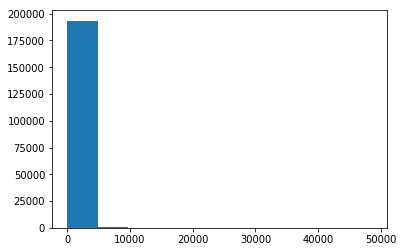

In [4]:
# orignial distributition
plt.hist(df.score)


In [5]:
df.score.describe()

count    194553.000000
mean        118.223255
std         936.231277
min           0.000000
25%           0.000000
50%           3.000000
75%          16.000000
max       48526.000000
Name: score, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194553 entries, 0 to 194552
Data columns (total 4 columns):
body     194553 non-null object
id       194553 non-null object
score    194553 non-null int64
title    194553 non-null object
dtypes: int64(1), object(3)
memory usage: 5.9+ MB


In [7]:
df.score.shape

(194553,)

In [8]:
print(df.score[df.score!=0].count()/df.score.shape[0])
print(df.score[df.score==0].count()/df.score.shape[0])
print(df.score[df.score >=100].count()/df.score.shape[0])


0.6835772257431137
0.3164227742568863
0.09641074668599302


label postive and negative jokes based on the score - form a binary label for us to model with.

In [9]:
# modeling score
df['is_funny'] = df.score.apply(lambda x: 1 if x > 1 else 0)


check the binary distribution

(array([ 80908.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 113645.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

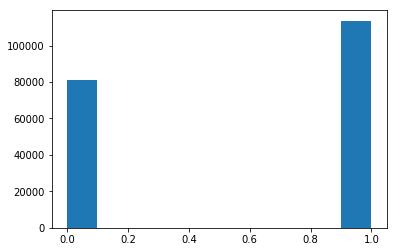

In [58]:
# modeling new binary distribution
plt.hist(df.is_funny)


Construct our tagert jokes format that are in line with our output from GPT-2 model.

In [11]:
# target
df['target'] = 'title: ' + df.title + ". " + "body: " + df.body
# df['target'] = df.title + ". " + df.body


Our final modeling data set

In [12]:
# finanl modeling dataset
final_modeling = df[['target', 'is_funny']]
print(final_modeling.shape)
final_modeling.head()


(194553, 2)


,target,is_funny
0,title: I hate how you cant even say black pain...,0
1,title: What's the difference between a Jew in ...,0
2,title: I recently went to America..... body: ....,0
3,"title: Brian raises his hand and says, “He’s i...",0
4,title: You hear about the University book stor...,0


In [13]:
final_modeling.is_funny.value_counts()

1    113645
0     80908
Name: is_funny, dtype: int64

In [16]:
# total sampels
print('total training samples: ',max(df.target.apply(lambda x: len(x))))


39757

### 2 - Preprocess Data

In [19]:
# sampel texts
texts = final_modeling.target.values

# tokenizing the data
maxlen = 50 # cut off sentences after 50 words
max_words = 10000 # consider only top 10000 common words in our samples

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts) # texts to seq
word_index = tokenizer.word_index # index

print('found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen) # padding
labels = np.array(final_modeling.is_funny.values)

print('shape of data tensor:',data.shape)
print('shape of labels tensor:',labels.shape)


Found 98403 unique tokens


In [21]:
# shuffle the data that splits randomly for train and dev
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


### 3 - Loading the pre-trained word embeddings
(Note we are using glove embeeding for the classifier, as we take the input from the GPT-2 pre-trained)


In [36]:
# we would use standford's GloVe pre-trained word embeddings
# download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-03-25 22:21:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-25 22:21:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-25 22:21:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [38]:
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


Parsing the Glove embeddings

In [22]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors.'%len(embeddings_index))



Found 400000 word vectors:


Preparing Glove word embedding matrix

In [23]:
# preparing glove word embeddings matrix
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
            # for words not in embedding index values will be zeros


In [24]:
embedding_matrix.shape

(10000, 300)

### 4 - Training

In [25]:
# a - helper function for plotting the results
def plot_result(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1']
    val_f1 = history.history['val_f1']
  
    epochs = range(1, len(acc)+1)
        
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.figure()

    plt.plot(epochs, f1, label='Training f-measure')
    plt.plot(epochs, val_f1, label='Validation f-measure')
    plt.title('Training and validation f-measure')
    plt.xlabel('epochs')
    plt.ylabel('f1')
    plt.legend()

    plt.show()
    

In [272]:
# b - helper for computing f1-measure as a metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


### 1 - feed-forward network with dense layers on top of embedding layer

In [302]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 300)           3000000   
_________________________________________________________________
flatten_8 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                960064    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 3,960,129
Trainable params: 3,960,129
Non-trainable params: 0
_________________________________________________________________


In [28]:
# embedding layers
e = Embedding(max_words, embedding_dim, input_length=maxlen,\
              weights=[embedding_matrix], trainable=False) # trainable set False for not updating the weights


In [199]:
# 2
# model = Sequential()
# model.add(e)
# model.add(Flatten())

# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3)) # adding regularization

# model.add(Dense(1, activation='sigmoid'))
# model.summary()


# model = Sequential()
# model.add(e)
# model.add(SimpleRNN(64, dropout=0.1))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()


# model = Sequential()
# model.add(e)
# model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.3, return_sequences=True)))
# model.add(SeqSelfAttention(attention_activation='relu'))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))
# model.summary()


model = Sequential()
model.add(e)
model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.3, return_sequences=True)))
# model.add(SeqSelfAttention(attention_activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='softmax'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           3000000   
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 50, 128)           186880    
_________________________________________________________________
flatten_53 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                409664    
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 33        
Total params: 3,598,657
Trainable params: 598,657
Non-trainable params: 3,000,000
____________________________________________________________

In [306]:
# # load pre-trained word embeddings into the embedding layer and freeze it
# model.layers[0].set_weights([embedding_matrix])
# model.layers[0].trainable = False

In [200]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=10, batch_size=1000, validation_split=0.1)

# model.compile(optimizer=Adagrad(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
# history = model.fit(data, labels, epochs=15, batch_size=800, validation_split=0.1)



Train on 175097 samples, validate on 19456 samples
Epoch 1/10
175097/175097 [==============================] - 228s 1ms/step - loss: 0.6742 - acc: 0.5840 - f1: 0.7372 - val_loss: 0.6694 - val_acc: 0.5855 - val_f1: 0.7384
Epoch 2/10
175097/175097 [==============================] - 211s 1ms/step - loss: 0.6681 - acc: 0.5862 - f1: 0.7362 - val_loss: 0.6646 - val_acc: 0.5921 - val_f1: 0.7382
Epoch 3/10
175097/175097 [==============================] - 267s 2ms/step - loss: 0.6638 - acc: 0.5977 - f1: 0.7291 - val_loss: 0.6600 - val_acc: 0.6016 - val_f1: 0.7330
Epoch 4/10
175097/175097 [==============================] - 207s 1ms/step - loss: 0.6604 - acc: 0.6032 - f1: 0.7230 - val_loss: 0.6568 - val_acc: 0.6119 - val_f1: 0.7269
Epoch 5/10
175097/175097 [==============================] - 210s 1ms/step - loss: 0.6579 - acc: 0.6076 - f1: 0.7176 - val_loss: 0.6554 - val_acc: 0.6111 - val_f1: 0.7258
Epoch 6/10
175097/175097 [==============================] - 207s 1ms/step - loss: 0.6559 - acc: 0.6

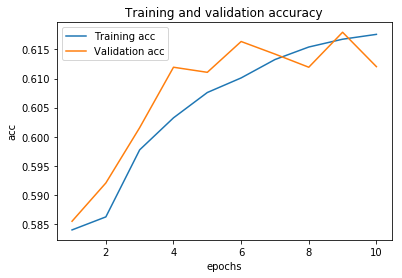

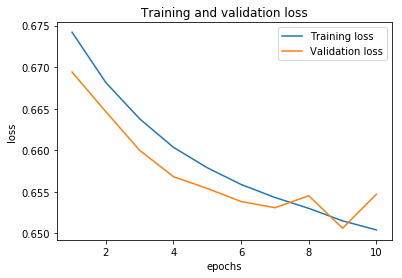

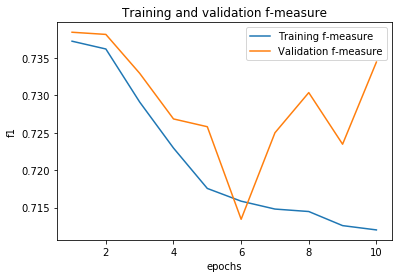

In [202]:
# plotting the results
plot_result(history)


In [280]:
# Save the model
# model.save('model.h5')

# Recreate the exact same model purely from the file
# model = keras.models.load_model('model.h5')
# model.summary()


### 5 - Prediction

In [275]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           3000000   
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 50, 128)           186880    
_________________________________________________________________
flatten_53 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                409664    
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 33        
Total params: 3,598,657
Trainable params: 598,657
Non-trainable params: 3,000,000
____________________________________________________________

In [259]:
### c - helper function to make a post request from our flask server

def request_jokes(url, question):
    """
    """
    
    while True:
        data = {'joke_title': question}
        r = requests.post(url=url, data=data)
#         r = requests.get(url=url + "?joke_title=" + question)
        ans = [r.text]
        if ans[0]=="Failed" or set(ans[0].split())==set(question.split()):
            r = requests.post(url=url, data=data)
#             r = requests.get(url=url + "?joke_title=" + question)
            ans = [r.text]
        else:
            return ans

### d - helper to generate jokes and classify humorous or not         
def request_prediction(model, question):
    """
    """
    
    out = []
    for i in range(len(question)):
        
        # data to be sent to api 
        ans = request_jokes(url=url, question=question[i])

        ### tokenizing
        tokenizer.fit_on_texts(ans)
        token_seq = tokenizer.texts_to_sequences(ans) # text to seq
        token_seq_pad = pad_sequences(token_seq, maxlen=maxlen) # pad seq

        # process answer - after body
        if ans[0].partition(question[i])[-1][0:8] == '\n body:':
            ans_jokes = ans[0].partition(question[i])[-1].partition('body: ')[-1]
        else:
            ans_jokes = ans[0].partition(question[i])[-1]

        # concatenate contents with title + body
        content = "title: " + question[i] + "\n" + "body:" + ans_jokes
        print(str([i+1])+"- jokes "+str(i+1)+": "+ content)

        # prepare results
        result = content, model.predict_classes(token_seq_pad)[0][0], model.predict_proba(token_seq_pad)[0][0]
        out.append(result)

    prediction_result = pd.DataFrame(out, columns=['jokes', 'is_funny', 'proba'])
    return prediction_result


Let's see 100 samples jokes titles

In [260]:
# question (jokes titles) list setup
question = ["""Why is it so hard to break up with a Japanese Girl? """,
            """Why did the chicken cross the road? """,
            """Why did the producers of 007 films use government debt to fund their newest film? """,
            """I feel so bad for the necrophiliac's sister. """,
            """What's the difference between you and a Calendar? """,
            """This guy proposed to his wife after walking away from a terrible car accident without a scratch. He said "Life's too short and it can end at any time." """,
            """Roses are red. """,
            """These reports of a major snowstorm hitting the Northeast don't concern me. """,
            """Those ads actually ran. """,
            """Burnt my Hawaiian pizza today. """,
            """I hate how you cant even say black paint anymore. """,
            """What's the difference between a Jew in Nazi Germany and pizza ? """, 
            """I recently went to America.... """,
            """Brian raises his hand and says, “He’s in Heaven.” """,
            """You hear about the University book store worker who was charged for stealing $20,000 worth of books? """,
            """Why is it unknown on how pterodactyls urinate especially during flight? """,
            """Why women need legs? """,
            """I walked into a PETA adoption center and the receptionist asked me what kind of dog I wanted """,
            """How did TV studios make words appear on screen before computers? """,
            """How do you find Will Smith in the snow? """, 
            """Remember when you were a kid and when you cried your parents said, "I'll give you a reason to cry"? """,
            """Remember, you can't spell Valentine's Day without... """,
            """Happy try not to jump off a bridge day! """,
            """My boss said to me, "you're the worst train driver ever. How many have you derailed this year?" """,
            """If I get a bird I'm naming it Trump """,
            """I was going to get a headjob for Valentines Day """,
            """A mother went into a coma after giving birth to twins """,
            """What do you call an exercise machine with a strobe light? """,
            """My dad has a heart of a lion """,
            """Smaller babies may be delivered by a stork. """,
            """A monkey is getting stoned in a zoo... """,
            """I've translated a popular Russian joke to English , wanna hear you reaction )) """,
            """What did the mommy bean say to her son when he asked for money? """,
            """When You Break Up At 11:59 Tonight """,
            """I wanted to buy an Audi. """,
            """I'm Trying to Remember The Name of A Song """,
            """What are minorities? """,
            """Did you hear that Donald Trump is technically a plant? """,
            """i had trouble swallowing a viagra last night """,
            """What is the king of all school supplies? """,
            """A rugby player was hurt very badly during a scrum and he had both of his ears ripped off... """,
            """A man was in his front yard mowing grass when his attractive blonde female !! """,
            """A woman runs into a doctor’s office and says “DOCTOR! DOCTOR! You have to help me! Everywhere I touch on my body it hurts!” """,
            """Why did the producers of 007 films use government debt to fund their newest film? """,
            """Pocket empty day ! """,
            """I want to see that new movie coming out with Scarlett Johannson… """,
            """Man gets lost in the desert. """,
            """Site of the 2017 Dane county massacre. """,
            """He fucked what? """,
            """My wife wants to eat somewhere shes never eaten before for V-Day """,
            """I was offered sex with a 21 yr old today """,
            """3 women talk """,
            """There are two types of people """,
            """Why did the computer squeak? """,
            """i found a place where the recycling rate is 98%. """,
            """Valentine's day fights """,
            """I feel so bad for the necrophiliac's sister """,
            """Julian Lennon messed up breakfast """,
            """I hear the Mexicans are planning an attack on America """,
            """I bought my friend an elephant for their room. """,
            """You're laughing because I'm laughing. """,
            """his guy proposed to his wife after walking away from a terrible car accident without a scratch. He said "Life's too short and it can end at any time." """,
            """First woman on mars. """,
            """Bad Advertisement """,
            """Those ads actually ran. """,
            """Why is the camel called the ship of the desert? """,
            """A Man Gets Really Drunk """,
            """What's the best thing about living in Switzerland? """,
            """A milestone """,
            """What part of the house got busted for drugs? """,
            """Relationships are a lot like algebra. """,
            """If Harry Potter were about pirates: """,
            """US Politics are """,
            """What's a ninjas favorite drink? """,
            """I used to hate the ballet """,
            """Life is like a diploma """,
            """ How do you encourage a bear to eat cheese? """,
            """Why was the orchestra teacher angry? """,
            """A fat man is watching television """,
            """In the beginning, God created the dog. """,
            """What's the quickest way to get in touch with your inner self? """,
            """What do you get when you combine Richard Simmons with Stephen Hawking? """,
            """A marketing executive walks into a bar """,
            """What do you call the presidential toilet? """,
            """Why is Tumblr bad for you? """,
            """What is the shittiest part of Object Oriented Programming? """,
            """Dad Joke """,
            """I love open-minded people. """,
            """Who came first. The chicken or the egg """,
            """Where do you find a dog with no legs? """,
            """What's the deal with airline food? """,
            """I like my soda like I like my women """,
            """What is the worst icebreaker? """,
            """What are your thoughts on monorails? """,
            """What's a pirate's favorite letter? """,
            """What do you call a rabbit roaming with a pack of lions? """,
            """How do you make a tissue dance? """,
            """I just got a haircut, but I'm not sure I like it. """,
            """How do you make Holy Water? """,
            """What's the most dangerous animal in the world? """       
                        
           ]


In [261]:
question_3 = question*3
len(question_3)


300

In [262]:
# question = ["""Why is it so hard to break up with a Japanese Girl? """,
#             """Why did the chicken cross the road? """,
#             """I feel so bad for the necrophiliac's sister. """,
#             """What's the difference between you and a Calendar? """,
#             """These reports of a major snowstorm hitting the Northeast don't concern me. """,
#             """Those ads actually ran. """,
#             """Burnt my Hawaiian pizza today. """,
#             """I hate how you cant even say black paint anymore. """,   
#            ]


In [263]:
# check
print("total number of jokes:", len(question_3))


total number of jokes: 300


##### open flask app first and run below for the preudction results

In [264]:
# flask server url
url = "http://127.0.0.1:5000/generate" # local
# url = "http://34.77.96.4:5000/generate_api?joke_title=" # on gpu

# make predictions
prediction_result = request_prediction(model, question_3)


[1]- jokes 1: title: Why is it so hard to break up with a Japanese Girl? 
body: She's my mother.
[2]- jokes 2: title: Why did the chicken cross the road? 
body:

"I saw him"

"What's a chicken's favorite color?"

"Red"

"What did the chicken say to the guy who was making fun of him?"

"I'm sorry"

"I guess you couldn't have a good one"
[3]- jokes 3: title: Why did the producers of 007 films use government debt to fund their newest film? 
body:

I'm not sure, it was just the most exciting thing to be a Bond villain.
[4]- jokes 4: title: I feel so bad for the necrophiliac's sister. 
body: 

"This woman is a disgrace!"
[5]- jokes 5: title: What's the difference between you and a Calendar? 
body:
 body: I got one with a Calendar." - Chris Perna
[6]- jokes 6: title: This guy proposed to his wife after walking away from a terrible car accident without a scratch. He said "Life's too short and it can end at any time." 
body: He asked how she felt about the proposal. She replied "I'm a wreck." 

[44]- jokes 44: title: Why did the producers of 007 films use government debt to fund their newest film? 
body:

The producers and actors use the same script for their latest film. (Source: "The Big Short"
[45]- jokes 45: title: Pocket empty day ! 
body:

The little guy says ''I'm so sorry. I'll do it again tomorrow.''

''What for next day and how many?"

''I don't know, I just saw you in today's magazine.''
[46]- jokes 46: title: I want to see that new movie coming out with Scarlett Johannson… 
body:
 body: I want to see that new movie coming out with Scarlett Johannson…
I am going to give her the best time of her life…
[47]- jokes 47: title: Man gets lost in the desert. 
body:

"You look like a bull," he whispers to his guide.

"What do you mean?" says the guide.

"Your eyes are yellow, you must be thirsty, you are half naked and you have nothing to eat."
[48]- jokes 48: title: Site of the 2017 Dane county massacre. 
body:

 (Courtesy of The Daily News)
[49]- jokes 49: title: He fuck

[92]- jokes 92: title: I like my soda like I like my women 
body:

'Cause I always drink with a grin on my face
[93]- jokes 93: title: What is the worst icebreaker? 
body:
 
The one that has no head.
[94]- jokes 94: title: What are your thoughts on monorails? 
body:
I would like to hear from you: what's your favorite method for transporting people between airports? What are your thoughts on trains? 
Thank you for reading, 
I really appreciate it.
Thank you for reading,
I really appreciate it.
I really appreciate it!
[95]- jokes 95: title: What's a pirate's favorite letter? 
body:

A ducking a.

* * *

I had the opportunity to hear the President say this to his chief of staff in the South Lawn of the White House: "I'm going to have to let you go, because I've got to go to a meeting today."
[96]- jokes 96: title: What do you call a rabbit roaming with a pack of lions? 
body:

A lynching!
[97]- jokes 97: title: How do you make a tissue dance? 
body:
Body: You make it go round with all of 

[141]- jokes 141: title: A rugby player was hurt very badly during a scrum and he had both of his ears ripped off... 
body:

The doctor came in and said, "I'm sorry, but this was an accident."

The player said to the doctor, "Do you think I deserve it?"
The doctor said, "I don't know, but if you come back and see me tomorrow, I will give you an ear replacement."
[142]- jokes 142: title: A man was in his front yard mowing grass when his attractive blonde female !! 
body: woman came running out. "What are you looking at with that balding, big ass, black face?"  The man answered, "I've got to pee and I'm worried about you, I'm running out of pee cups."

The woman continued to walk toward him when he turned to her again, "And you're thinking of fucking me?"

"I'm just thinking about the dog."
[143]- jokes 143: title: A woman runs into a doctor’s office and says “DOCTOR! DOCTOR! You have to help me! Everywhere I touch on my body it hurts!” 
body:
The doctor looks at her and says “If you nee

[186]- jokes 186: title: What is the shittiest part of Object Oriented Programming? 
body:

The most advanced parts do it the hard way.
[187]- jokes 187: title: Dad Joke 
body:
 body: What's a man's favorite Joke?

You never ask a man what his favorite joke is. He just laughs and says "oh, I'll never figure that one out."
[188]- jokes 188: title: I love open-minded people. 
body:

P.s. I don't understand why people like me don't like you.

P.n.t. I'm not a racist.

P.n.r.s. I'm not a bigot.
[189]- jokes 189: title: Who came first. The chicken or the egg 
body:?"

The young man answers "The egg"

The young man says "Well I thought I made the right choice" 

And the old man replies "Well I think you just made the wrong choice"
[190]- jokes 190: title: Where do you find a dog with no legs? 
body:

A friend of mine, I guess you could say. 

A dog, yes, a dog. 

And when you ask him where it came from? 

He says "my dad kept it for me."
[191]- jokes 191: title: What's the deal with airline 

[235]- jokes 235: title: I wanted to buy an Audi. 
body:

The waitress looks very puzzled. 

She explains: "I thought you wanted to buy an Audi, but you don't.  You want to buy an Audi."

The other diner asks: "Well, what do you want it for?" 

She responds, "For the price of an Audi, your wife can have all the power in the world!"
[236]- jokes 236: title: I'm Trying to Remember The Name of A Song 
body:
 Body:  

Hey, how'd you hear that? 

I do. 

I'm trying to remember the name of a song. 

I want to know what it's called when you stand on it and go "ooh ooh ooh ooh ooh ooh ooh ooh ooh ooh". 

No idea, I just thought of a song.
[237]- jokes 237: title: What are minorities? 
body: 

People that have a different opinion of the blacks than the whites.
[238]- jokes 238: title: Did you hear that Donald Trump is technically a plant? 
body:


Yes, the only thing worse than a plant is a plant who doesn't get it.
[239]- jokes 239: title: i had trouble swallowing a viagra last night 
body:

b

[276]- jokes 276: title: Life is like a diploma 
body:!"
[277]- jokes 277: title:  How do you encourage a bear to eat cheese? 
body:
[278]- jokes 278: title: Why was the orchestra teacher angry? 
body:

A) "The kid was crying"
[279]- jokes 279: title: A fat man is watching television 
body:
And he says: 
"Wow! I've never seen anything like this!" The man looks at the woman and says
"My wife is really getting hot right now!"
[280]- jokes 280: title: In the beginning, God created the dog. 
body: The dog walks into a bar. After a while, the dog says to himself, "This is the future."  After a few beers, the dog then decides to go on a date.  A woman approaches the dog and says, "I don't believe in this dog.  It would have been a good date but I didn't want to ruin it." The dog shakes his head and says, "I'll show you tomorrow."
[281]- jokes 281: title: What's the quickest way to get in touch with your inner self? 
body:

"Just say NO and say YES!"
[282]- jokes 282: title: What do you get w

In [268]:
# output pandas dataframe
prediction_result


,jokes,is_funny,proba
0,title: Why is it so hard to break up with a Ja...,0,0.474580
1,title: Why did the chicken cross the road? \nb...,1,0.687178
2,title: Why did the producers of 007 films use ...,1,0.515699
3,title: I feel so bad for the necrophiliac's si...,0,0.463882
4,title: What's the difference between you and a...,1,0.716760
5,title: This guy proposed to his wife after wal...,1,0.770248
6,title: Roses are red. \nbody:\n\nSans: They're...,1,0.767903
7,title: These reports of a major snowstorm hitt...,1,0.755747
8,title: Those ads actually ran. \nbody: When so...,1,0.697855
9,title: Burnt my Hawaiian pizza today. \nbody: ...,1,0.503951


In [279]:
# humoruous percentage
prediction_result.is_funny.value_counts()[1]/len(prediction_result)


0.8033333333333333

In [267]:
prediction_result.to_csv('jokes_recognition.csv', index=False)
